# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
![kaggle1.png](attachment:kaggle1.png)
![kaggle2.png](attachment:kaggle2.png)
2. Scroll down to API and click Create New API Token.
![kaggle3.png](attachment:kaggle3.png)
![kaggle4.png](attachment:kaggle4.png)
3. Open up `kaggle.json` and use the username and key.
![kaggle5.png](attachment:kaggle5.png)

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [1]:
!pip install -U pip -q
!pip install -U setuptools wheel -q
!pip install -U "mxnet<2.0.0" bokeh==2.0.1 -q
!pip install autogluon --no-cache-dir -q
# Without --no-cache-dir, smaller aws instances may have trouble installing

NameError: name 'autogluon' is not defined

### Setup Kaggle API Key

In [2]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "my_user_name"
kaggle_key = "may_api_key"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the [bike sharing demand competition](https://www.kaggle.com/c/bike-sharing-demand) and agree to the terms
![kaggle6.png](attachment:kaggle6.png)

In [4]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [90]:
! pip list | grep autogluon.tabular

autogluon.tabular                1.1.0


In [5]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor
from autogluon.common import space

label = 'count'
eval_metric = 'root_mean_squared_log_error'
excluded_model_types = ['KNN', 'NN_TORCH']

In [6]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


>From [Kaggle](https://www.kaggle.com/competitions/bike-sharing-demand/overview)
Evaluation<br>
Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE).

-> Apply log conversion for our label.


In [7]:
train['count'] = np.log1p(train['count'])

In [8]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,4.591364
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,0.693147
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,3.761200
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,4.983607
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,5.652489
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,6.885510
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,1.419454


In [9]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv", parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [10]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset.
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [11]:
predictor = TabularPredictor(label = label).fit(train.drop(["casual", "registered"], axis=1),
                                              excluded_model_types = excluded_model_types,
                                              time_limit = 600,
                                              presets = 'best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240613_100512"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240613_100512/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 194 seconds

### Review AutoGluon's training run with ranking of models that did the best.

In [59]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.847063,root_mean_squared_error,44.021005,364.523240,0.001104,0.029873,3,True,9
1,LightGBM_BAG_L2,-0.850681,root_mean_squared_error,42.994677,291.182463,0.120875,29.091213,2,True,7
2,LightGBMXT_BAG_L2,-0.852394,root_mean_squared_error,43.162486,293.915377,0.288684,31.824127,2,True,6
3,RandomForestMSE_BAG_L2,-0.863314,root_mean_squared_error,43.610342,303.578027,0.736540,41.486777,2,True,8
4,RandomForestMSE_BAG_L1,-0.865332,root_mean_squared_error,0.829942,18.649203,0.829942,18.649203,1,True,3
5,WeightedEnsemble_L2,-0.865332,root_mean_squared_error,0.831245,18.680743,0.001303,0.031541,2,True,5
6,LightGBM_BAG_L1,-1.005246,root_mean_squared_error,3.932532,56.733718,3.932532,56.733718,1,True,2
7,LightGBMXT_BAG_L1,-1.005731,root_mean_squared_error,37.999609,150.343320,37.999609,150.343320,1,True,1
8,CatBoost_BAG_L1,-1.072325,root_mean_squared_error,0.111719,36.365009,0.111719,36.365009,1,True,4


### Create predictions from test dataset

In [13]:
predictions = np.expm1(predictor.predict(test))
predictions.head()

0    43.071491
1    70.856056
2    70.856056
3    72.786591
4    72.786591
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [14]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      142.212540
std       121.198448
min         5.268152
25%        50.188404
50%        95.515038
75%       202.370819
max       564.362305
Name: count, dtype: float64

In [15]:
# How many negative values do we have?
len([x for x in predictions.values if x <0])

0

In [16]:
# No need to set them to zero because label is log transformed

### Set predictions to submission dataframe, save, and submit

In [17]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [18]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:00<00:00, 987kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [19]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2024-06-13 10:17:20  first raw submission               complete  1.26114      1.26114       
submission_new_hpo.csv       2024-06-13 09:07:10  new features with hyperparameters  error                                
submission_new_hpo.csv       2024-06-13 08:53:21  new features with hyperparameters  error                                
submission_new_hpo.csv       2024-06-13 08:52:43  new features with hyperparameters  error                                


#### Initial score of `?`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

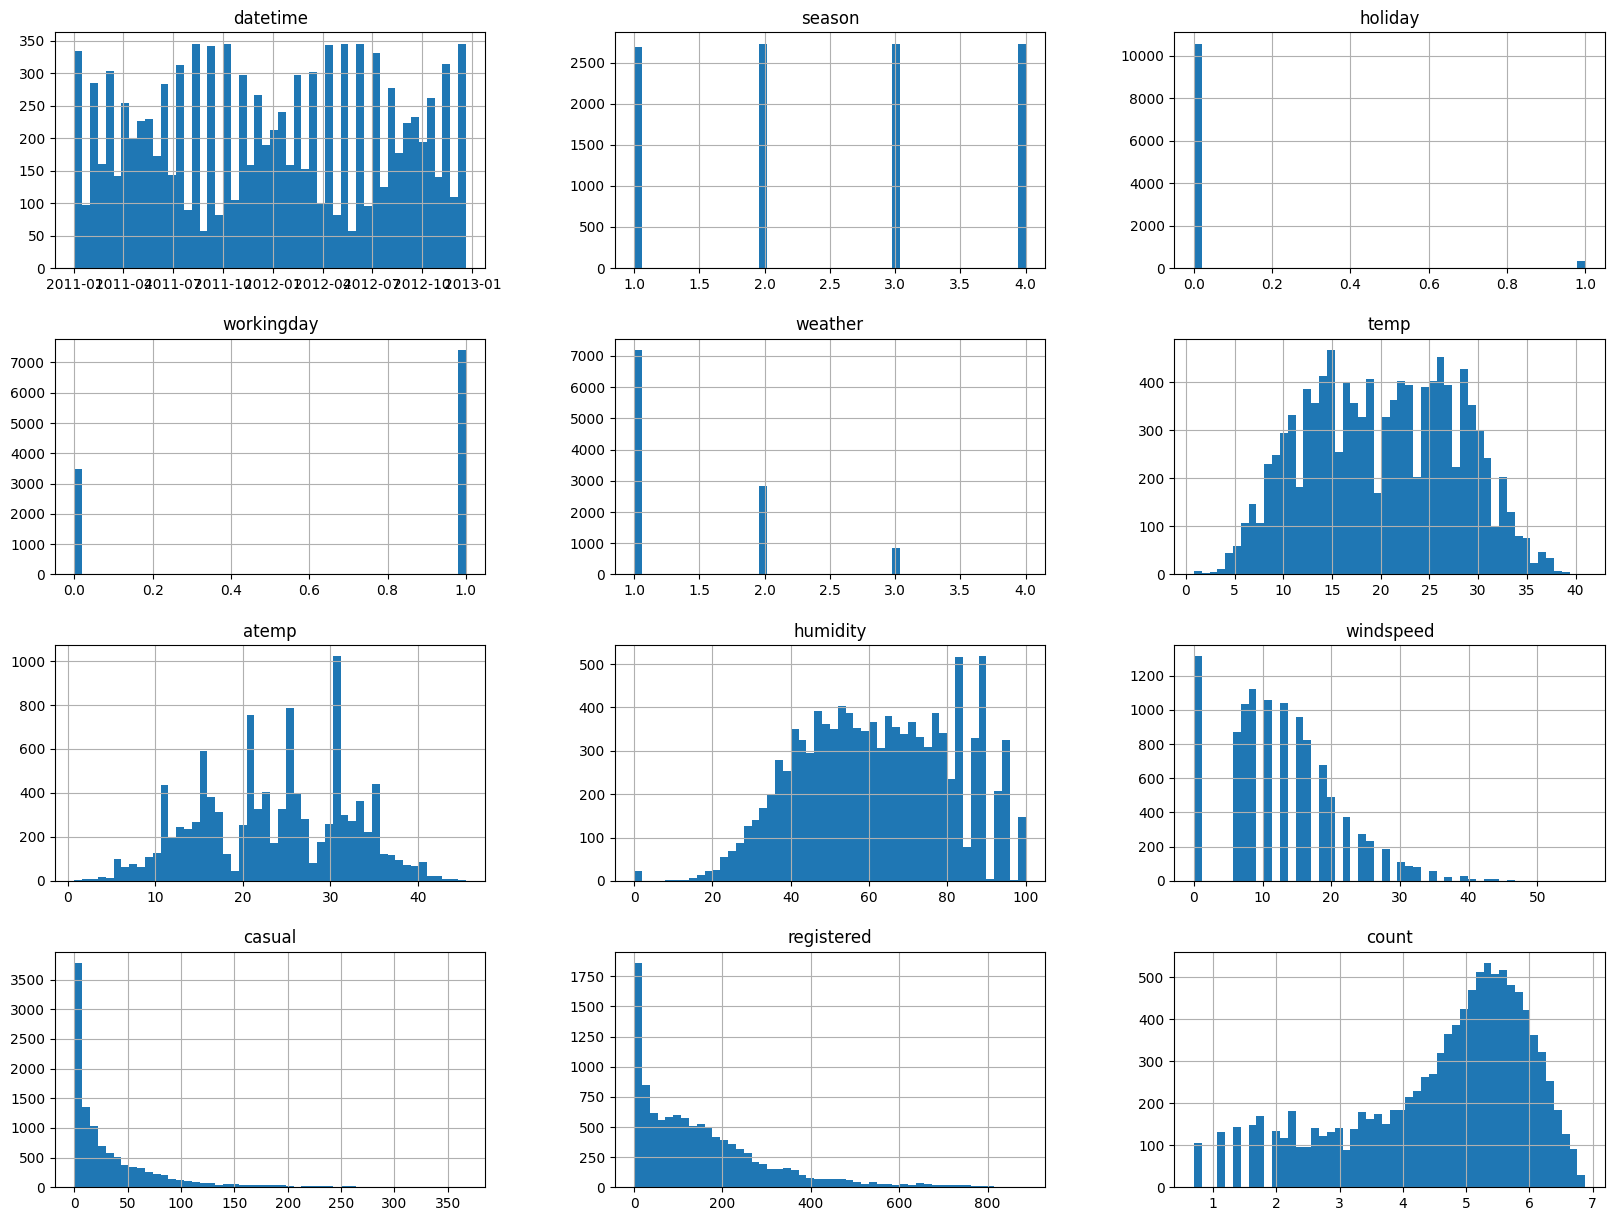

In [20]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(bins=50, figsize=(20, 15));

In [21]:
# create a new feature
def time_process(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.dayofweek

    return df

train = time_process(train)
test = time_process(test)

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [22]:
# create a new feature
def set_type_category(df, target_col_lst):

  for col_name in target_col_lst:
    df[col_name] = df[col_name].astype('category')

  return df

target_col_lst = ['season', 'weather', 'year', 'month', 'day', 'hour', 'weekday']
train = set_type_category(train, target_col_lst)
test = set_type_category(test, target_col_lst)


In [23]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,2.833213,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,3.713572,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,3.496508,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,2.639057,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,0.693147,2011,1,1,4,5


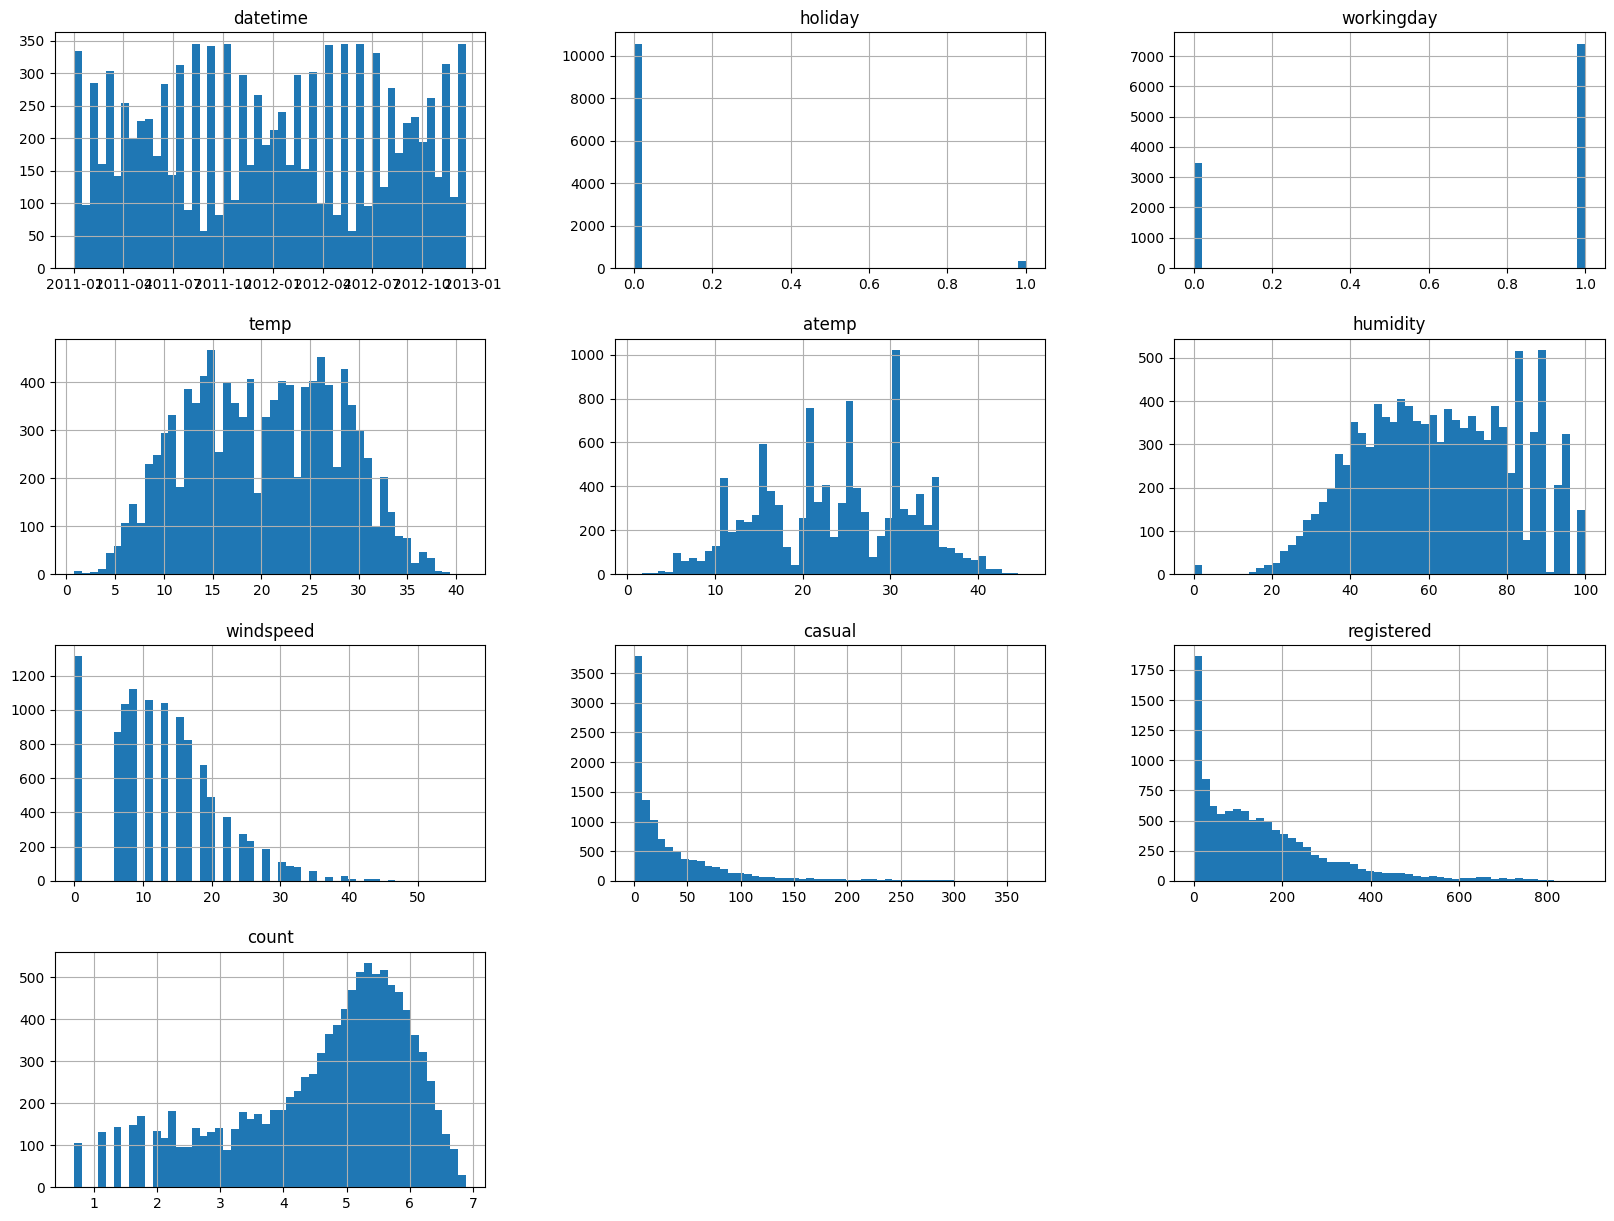

In [24]:
# View histogram of all features again now with the hour feature
train.hist(bins=50, figsize=(20, 15));

## Step 5: Rerun the model with the same settings as before, just with more features

In [25]:
predictor_new_features = TabularPredictor(label=label).fit(train.drop(["casual", "registered"], axis=1),
                                              excluded_model_types = excluded_model_types,
                                              time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240613_101730"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240613_101730/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 189 seconds

In [58]:
predictor_new_features.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.260098,root_mean_squared_error,12.410445,378.009206,0.000884,0.040271,3,True,10
1,WeightedEnsemble_L2,-0.260821,root_mean_squared_error,11.088344,257.945546,0.001017,0.028141,2,True,6
2,LightGBM_BAG_L2,-0.266301,root_mean_squared_error,11.260614,290.261002,0.173287,32.343597,2,True,8
3,LightGBMXT_BAG_L1,-0.266572,root_mean_squared_error,5.608417,59.196684,5.608417,59.196684,1,True,1
4,LightGBMXT_BAG_L2,-0.266759,root_mean_squared_error,11.423527,293.030431,0.336200,35.113026,2,True,7
5,RandomForestMSE_BAG_L2,-0.266860,root_mean_squared_error,11.900074,310.512312,0.812747,52.594908,2,True,9
6,LightGBM_BAG_L1,-0.270568,root_mean_squared_error,3.661255,53.774899,3.661255,53.774899,1,True,2
7,ExtraTreesMSE_BAG_L1,-0.284227,root_mean_squared_error,0.640224,13.120304,0.640224,13.120304,1,True,5
8,RandomForestMSE_BAG_L1,-0.289948,root_mean_squared_error,0.675877,29.179156,0.675877,29.179156,1,True,3
9,CatBoost_BAG_L1,-0.310504,root_mean_squared_error,0.501553,102.646362,0.501553,102.646362,1,True,4


In [27]:
# Remember to set all negative values to zero

In [28]:
# Same submitting predictions
submission["count"] = np.expm1(predictor_new_features.predict(test))
submission.to_csv("submission_new_features.csv", index=False)

In [29]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100% 188k/188k [00:00<00:00, 913kB/s]
Successfully submitted to Bike Sharing Demand

In [30]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2024-06-13 10:28:06  new features                       complete  0.41008      0.41008       
submission.csv               2024-06-13 10:17:20  first raw submission               complete  1.26114      1.26114       
submission_new_hpo.csv       2024-06-13 09:07:10  new features with hyperparameters  error                                
submission_new_hpo.csv       2024-06-13 08:53:21  new features with hyperparameters  error                                


#### New Score of `?`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [31]:
def get_predict(train_, test_, hyperparameters_, hyperparameter_tune_kwargs_):
  predictor = TabularPredictor(label=label).fit(
    train_.drop(["casual", "registered"], axis=1),
    hyperparameters=hyperparameters_,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs_,
    time_limit=600, presets='best_quality',
    verbosity = 1
  )

  pred_values = np.expm1(predictor.predict(test_))

  return pred_values, predictor

In [55]:
gbm_options = {
    'num_boost_round': 100,
    'num_leaves': space.Int(lower=26, upper=66, default=36),  }

rf_options = {
    'n_estimators': space.Int(lower=20, upper=500, default=100),
}

cat_options = {
    'l2_leaf_reg':space.Int(lower=1, upper=30, default=3)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'RF': rf_options,
                   'CAT': cat_options
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'scheduler' : 'local',
    'searcher': search_strategy}

In [56]:
submission["count"], hpo_predictor = get_predict(train, test, hyperparameters, hyperparameter_tune_kwargs)
submission.to_csv("submission_new_hpo.csv", index=False)

No path specified. Models will be saved in: "AutogluonModels/ag-20240613_120627"


In [93]:
hpo_predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.274789,root_mean_squared_error,0.003586,357.869279,0.001198,0.047612,3,True,14
1,CatBoost_BAG_L2/T1,-0.277499,root_mean_squared_error,0.001960,275.740247,0.000156,54.170939,2,True,13
2,LightGBM_BAG_L2/T1,-0.277705,root_mean_squared_error,0.001995,257.682729,0.000191,36.113421,2,True,10
3,WeightedEnsemble_L2,-0.278190,root_mean_squared_error,0.002318,143.259618,0.001364,0.042386,2,True,9
4,RandomForest_BAG_L2/T2,-0.281977,root_mean_squared_error,0.002041,267.537307,0.000237,45.967998,2,True,12
5,RandomForest_BAG_L2/T1,-0.284286,root_mean_squared_error,0.001957,244.737325,0.000153,23.168017,2,True,11
6,RandomForest_BAG_L1/T5,-0.290750,root_mean_squared_error,0.000304,23.208998,0.000304,23.208998,1,True,7
7,RandomForest_BAG_L1/T2,-0.291195,root_mean_squared_error,0.000243,19.174214,0.000243,19.174214,1,True,4
8,RandomForest_BAG_L1/T4,-0.291904,root_mean_squared_error,0.000283,12.306442,0.000283,12.306442,1,True,6
9,RandomForest_BAG_L1/T1,-0.293273,root_mean_squared_error,0.000162,12.603955,0.000162,12.603955,1,True,3


In [60]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100% 188k/188k [00:00<00:00, 1.01MB/s]
Successfully submitted to Bike Sharing Demand

In [61]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 10

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-06-13 12:16:26  new features with hyperparameters  complete  0.42679      0.42679       
submission_new_hpo.csv       2024-06-13 11:59:41  new features with hyperparameters  complete  0.42898      0.42898       
submission_new_features.csv  2024-06-13 10:28:06  new features                       complete  0.41008      0.41008       
submission.csv               2024-06-13 10:17:20  first raw submission               complete  1.26114      1.26114       
submission_new_hpo.csv       2024-06-13 09:07:10  new features with hyperparameters  error                                
submission_new_hpo.csv       2024-06-13 08:53:21  new features with hyperparameters  error                                
submission_new_h

#### New Score of `?`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

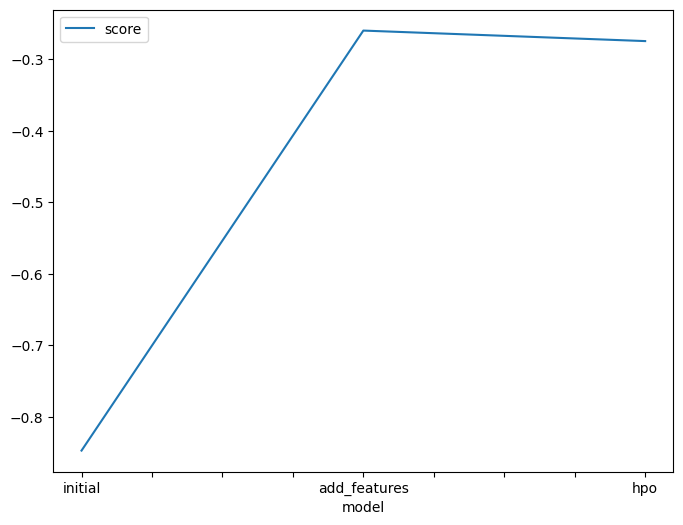

In [62]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)

score_lst = [-0.847063, -0.260098, -0.274789]

fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": score_lst
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

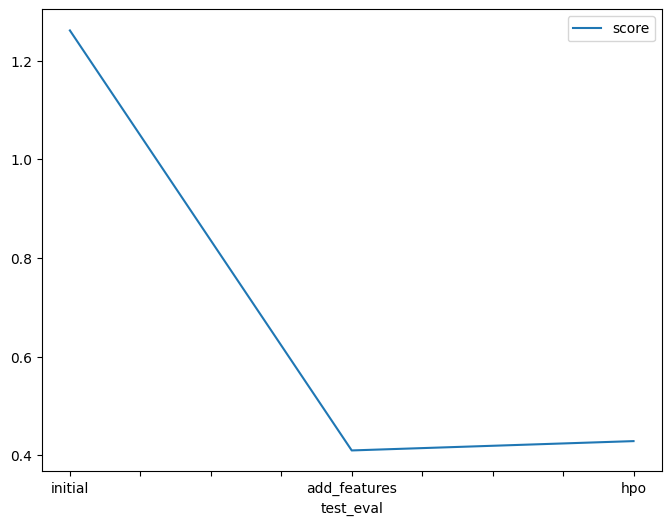

In [63]:
# Take the 3 kaggle scores and creating a line plot to show improvement

kaggle_score_lst = [1.26114, 0.41008, 0.42898]

fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": kaggle_score_lst
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [106]:
# The 3 hyperparameters we tuned with the kaggle score as the result
# Below is model weight in ensemble
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [0.14, 0.30, 0.12],
    "hpo2": [0.33, 0.17, 0.08],
    "hpo3": [0.38, 0.08, 0.04],
    "hpo4": [0.14, 0.08, 0.28],
    "hpo5": [0, 0.08, 0.16],
    "hpo6": [0, 0.04, 0.32],
    "hpo7": [0, 0.21, 0],
    "score": kaggle_score_lst
})

,model,hpo1,hpo2,hpo3,hpo4,hpo5,hpo6,hpo7,score
0,initial,0.14,0.33,0.38,0.14,0.00,0.00,0.00,1.26114
1,add_features,0.30,0.17,0.08,0.08,0.08,0.04,0.21,0.41008
2,hpo,0.12,0.08,0.04,0.28,0.16,0.32,0.00,0.42898


In [104]:
predictor.info()['model_info']['WeightedEnsemble_L3']['children_info']['S1F1']['model_weights']

{'RandomForestMSE_BAG_L1': 0.14285714285714285,
 'LightGBMXT_BAG_L2': 0.3333333333333333,
 'LightGBM_BAG_L2': 0.38095238095238093,
 'RandomForestMSE_BAG_L2': 0.14285714285714285}

In [102]:
predictor_new_features.info()['model_info']['WeightedEnsemble_L3']['children_info']['S1F1']['model_weights']

{'LightGBMXT_BAG_L1': 0.30434782608695654,
 'LightGBM_BAG_L1': 0.17391304347826086,
 'RandomForestMSE_BAG_L1': 0.08695652173913043,
 'ExtraTreesMSE_BAG_L1': 0.08695652173913043,
 'LightGBMXT_BAG_L2': 0.08695652173913043,
 'LightGBM_BAG_L2': 0.043478260869565216,
 'RandomForestMSE_BAG_L2': 0.21739130434782608}

In [103]:
hpo_predictor.info()['model_info']['WeightedEnsemble_L3']['children_info']['S1F1']['model_weights']

{'LightGBM_BAG_L1/T2': 0.12,
 'RandomForest_BAG_L1/T5': 0.08,
 'CatBoost_BAG_L1/T1': 0.04,
 'LightGBM_BAG_L2/T1': 0.28,
 'RandomForest_BAG_L2/T2': 0.16,
 'CatBoost_BAG_L2/T1': 0.32}